# **Required Downloads**

In [1]:
!pip install -q transformers
!pip install -q contractions
!pip install -q autocorrect
!pip install -q tensorflow

# **Required Imports**

In [2]:

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import RobertaTokenizer,TFRobertaForSequenceClassification
from transformers import XLNetTokenizer, TFXLNetForSequenceClassification
from transformers import ElectraTokenizer,TFElectraForSequenceClassification
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification,TFPreTrainedModel

import time

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report
import pandas as pd
import seaborn as sns

import tensorflow as tf
import json

import numpy as np
import pandas as pd


import os
import re

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize

import contractions
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score
from autocorrect import Speller



# **Data Prepration**

## Getting Data
- Importing Data
- Loading Data

### Importing Data 
- The following cell is importing data from google drive and storing the files to /home/Emotiondata directory.
- Data Source: 
> https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
DataDir = '/home/EmotionData/'
!mkdir /home/EmotionData
!unzip /content/drive/MyDrive/archive.zip 
!mv /content/*.txt /home/EmotionData

mkdir: cannot create directory ‘/home/EmotionData’: File exists
Archive:  /content/drive/MyDrive/archive.zip
  inflating: test.txt                
  inflating: train.txt               
  inflating: val.txt                 


### Loading Data
- The Following cell loads train, validation and test data to variables 
- Shows how the data looks from reading the file.
- Used Sources: 
>https://stackoverflow.com/questions/21546739/load-data-from-txt-with-pandas

In [5]:
def readDataEmotionData1(dataPath):
  data = pd.read_csv(DataDir+dataPath, sep=";", header=None, names = ['Text','Label'])
  return data;

trainData = readDataEmotionData1('train.txt')
valData = readDataEmotionData1('val.txt')
testData = readDataEmotionData1('test.txt')
# Shows how the data looks in the padas DataFrame after loading 
trainData.head()

,Text,Label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## Exploring Data


In [6]:
# The following function adds length coloum to pandas Dataframe
def addTextLength(dataFrame):
  lengthData = []
  for i in dataFrame['Text']:
    lengthData.append(len(i))
  dataFrame=dataFrame.assign(Length=lengthData)
  return dataFrame
trainData = addTextLength(trainData)
valData = addTextLength(valData)
testData = addTextLength(testData)
valData.head()

,Text,Label,Length
0,im feeling quite sad and sorry for myself but ...,sadness,69
1,i feel like i am still looking at a blank canv...,sadness,70
2,i feel like a faithful servant,love,30
3,i am just feeling cranky and blue,anger,33
4,i can have for a treat or if i am feeling festive,joy,49


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


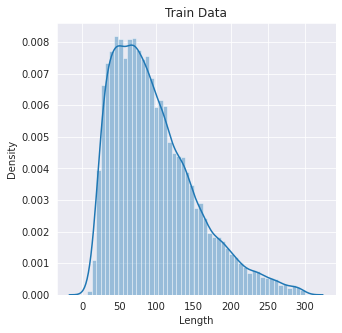

In [94]:
# This shows the distrubution of the number of characters length of the Text.
def plotDestrubrition(data,name):
  sns.set_style('darkgrid')
  plt.figure(figsize=(5,5))
  plt.title(name)
  sns.distplot(data)
  # plt.savefig('/models/Stats/TrainDataDestrubrition.eps',format='eps',dpi=1200)

plotDestrubrition(trainData['Length'],'Train Data')

In [8]:
maxSentanceLength = 300
trainData.describe()

,Length
count,16000.000000
mean,96.845812
std,55.904953
min,7.000000
25%,53.000000
50%,86.000000
75%,129.000000
max,300.000000


## Text Pre-Processing
- Decontraction
- Spell check


### Decontraction 
- Having contractions tends to drop vowels from words in English. By Decotracting words in the text, it standardizas the text which could be very useful while traning Text Classfication Model.

- Source:  
`https://www.geeksforgeeks.org/nlp-expand-contractions-in-text-processing/`<br />
`https://medium.com/analytics-vidhya/natural-language-processing-for-developers-912ee0fda979`





In [9]:
# This requries  contractions package.
# This Function accepts a Pandas Data Frame with sentences in column titled 'Text'.
def Decontracted(DataFrame):
  # This loop enumerates, giving 'i' being the index of the sentence which is denoted by 'text'.
  for i, text in enumerate(DataFrame['Text']):
    DataFrame['Text'][i] = contractions.fix(text)
  return DataFrame

# Calling Decontracted function on all three Datasets
trainData = Decontracted(trainData)
valData = Decontracted(valData)
testData = Decontracted(testData)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Checking Spelling 

- Training and Validation text containing misspelled words might not help the model recognize a pattern since a different token would be assigned during tokenization.
> **Note**: This will take really long time, remove or comment it if needed.

In [10]:
# This requires autocorrect package as Speller.
# This Function accepts a Pandas Data Frame with sentences in column titled 'Text'.
def SpellCheck(DataFrame):
  spell = Speller(lang='en')
  for i, text in enumerate(DataFrame['Text']):
      DataFrame['Text'][i] = str(spell(text))
  return DataFrame

# Calling SpellCheck function on all three Datasets
trainData = SpellCheck(trainData)
valData = SpellCheck(valData)
testData = SpellCheck(testData)

## Text Processing
- Labels Enconding
- Text Tokenization


### Label Encoding
- When making this model, we tried two methods for label encoding, those being one-hot encoding, and assigning an arbitrary integer value to each of the text classifiers.

- While training and testing the model, we found out that there was no substantial difference in accuracy. Therefore, we choose the second method with assigning an arbitrary integer value.

- In the dataset we are using there are following 6 classifiers and the corresponding listed below. <br />
` Anger: 0 
  Fear: 1
  Joy: 2
  Love: 3
  Sadness: 4
  Surprise: 5`
> **Note**: If you would like to use one-hot encoding instead of what we were using, return 'LabelsNames' instead of 'labels' in the LabelEncoding function. You may also need to change the loss function from SparseCategoricalCrossentropy to CategoricalCrossentropy in the model architecture.

In [11]:
# If one-hot encoding is being used requires CountVectorizer and TfidfVectorizer packages from sklearner.
# This Function accepts a Pandas Data Frame with sentences classifications in column titled 'Label'
def LabelEncoding(DataFrame):
  labels = []
  encodeVectorizer = CountVectorizer(analyzer = "word", tokenizer = None,lowercase=True, preprocessor = None, stop_words = None)
  encodedLabels = encodeVectorizer.fit_transform(DataFrame['Label']).toarray()
  LabelsNames = list(encodeVectorizer.get_feature_names())
  for i in DataFrame['Label']:
    labels.append((list(LabelsNames).index(i)))
  return labels,LabelsNames

# Calling LabelEncoding function on all three Datasets
encodedTrainLabels,TrainLabelFeatureNames = LabelEncoding(trainData)
encodedValLabels,ValLabelFeatureNames = LabelEncoding(valData)
encodedTestLabels,TestLabelFeatureNames = LabelEncoding(testData)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Text Tokenization
- With the use of AutoTokenizer from hugging face's python package called transformers, we are able to tokenize list of text sentences using the pretrained tokens from a given transformer model.
- The Hugging face's tokenizer has parameters for custom padding length which we used while making this model.
- The TextEncoding Function returns a tensor_slices dataset containing text encodings and their corresponding labels as in a format tensorflow requires with a custom tranning batch size.

> **Note**: Tokenization could be accomplished also using pre-trained model specfic tokenizer insted of AutoTokenizer, ex. AutoTokenizer.from_pretrained('bert-base-uncased') which return the same tokenizer as BertTokenizer.from_pretrained('bert-base-uncased')


In [12]:
# This Function requires AutoTokenizer packages from transformers and import tensorflow as tf.
def TextEncoding(
                 # The model specific tokenizer ex. 'bert-base-uncased'
                 tokenizerType,
                 # The list of data containing Text 
                 dataTextList, 
                 # The list of Corresponding Classification of dataTextList in one-hot or other encoding
                 LabelList, 
                 # The Traing Batch Size.
                 batchSize,
                 # The Shuffling Parameter
                 shufflingParameter,
                 # The Padding Length
                 maxLen):
  tokenizer = AutoTokenizer.from_pretrained(tokenizerType)
  
  textEncodings = tokenizer(dataTextList,
                            truncation=True, 
                            max_length = maxLen,
                            padding="max_length")
  
  dataset = tf.data.Dataset.from_tensor_slices((
    dict(textEncodings),
    LabelList
    ))
  dataset = dataset.shuffle(shufflingParameter).batch(batchSize)
  return dataset,tokenizer

# **Model Bulding and Training**
- Requried Entities
- Model Building
- Model Tranning 
- Model Saving

## Requried Entities
- Google Cloud Authorization
- Requried Directories
- Other Required Variables


### Google Cloud Authorization
- This contains cloud authorization to our project for transfer data from to google storage buckets


In [15]:
!gcloud auth login
!gcloud config set project oval-tuner-326314

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=wcCFp4XZTEetU5TtOvNMXqcbx3a67g&prompt=consent&access_type=offline&code_challenge=eoZuDMirZT5r-OxKeMzsEA_wqBHQYAGrXJKLIs85nzc&code_challenge_method=S256

Enter verification code: 4/1AX4XfWikTJ3gSZjbNt2ReCSkNkgshPdd787Rwu6zIL-qLLTAZ9HI3R0zbOc

You are now logged in as [anirudhovn@gmail.com].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID
Updated property [core/project].


### Requried Directories
- This contains requried directories to save models and data after tranning.

In [20]:
!mkdir /models/
!mkdir /models/Stats/

!mkdir /models/Bert
!mkdir /models/Bert/BertPreTrainedModel/
!mkdir /models/Bert/BertTokenizer/

!mkdir /models/DistilBert
!mkdir /models/DistilBert/DistilBertPreTrainedModel/
!mkdir /models/DistilBert/DistilBertTokenizer/

!mkdir /models/Roberta
!mkdir /models/Roberta/RobertaPreTrainedModel/
!mkdir /models/Roberta/RobertaTokenizer/

!mkdir /models/Electra
!mkdir /models/Electra/ElectraPreTrainedModel/
!mkdir /models/Electra/ElectraTokenizer/

!mkdir /models/MobileBert
!mkdir /models/MobileBert/MobileBertPreTrainedModel/
!mkdir /models/MobileBert/MobileBertTokenizer/


mkdir: cannot create directory ‘/models/’: File exists
mkdir: cannot create directory ‘/models/Stats/’: File exists
mkdir: cannot create directory ‘/models/Roberta’: File exists
mkdir: cannot create directory ‘/models/Roberta/RobertaPreTrainedModel/’: File exists
mkdir: cannot create directory ‘/models/Roberta/RobertaTokenizer/’: File exists


### Other Required Variables
- This contains other requried variables for model building and tranning.

In [ ]:
# This is used to save excuation times.
timeData = pd.DataFrame(columns= ['Training(min) ', 'Evalution(min)']).rename_axis('Models', axis=1)

## Model Building
- Model Architecture
- Plotting Epochs
- F1-Marco 
- Model Tranning Function 
- Model Saving(Colab)
- Sources: <br />
 - https://www.youtube.com/watch?v=qFJeN9V1ZsI <br />
 - https://www.youtube.com/watch?v=tPYj3fFJGjk <br /> 
 - https://www.youtube.com/watch?v=urlkrueSXpI <br />
 - https://www.youtube.com/watch?v=hOCDJyZ6quA <br />
 - https://www.youtube.com/watch?v=xI0HHN5XKDo <br />
 - https://www.youtube.com/watch?v=TQQlZhbC5ps <br />
 - https://www.youtube.com/watch?v=GSt00_-0ncQ <br />
 - https://www.youtube.com/watch?v=V1-Hm2rNkik <br />
 - https://www.youtube.com/watch?v=HzwM0ClAmOM <br />
 - https://huggingface.co/docs/transformers/master/model_doc/bert <br />
 - https://huggingface.co/docs/transformers/master/model_doc/electra <br />
 - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html <br />
> **Note**: We had no prior knowledge in ML or Neurl Networks, so we watched some paritially or fully the videos listed above.

### Model Architecture
- We edited the model architecture while monitoring accuracy and loss per epoch.
- Pre-Trained Transformer Seq to Seq model accepts input_ids and attention mask as input layer. Where the shap of both input_ids and attention mask is the padding length, we choose(275).
- Then the output embeddings of the pre-trained transformer model is passed to Dense layer which consist of 1000 nodes with relu activation function.
- Having an a BatchNormalization layer after 1000 node Dense layer, we obsurved an increase in accuracy and no change to loss.
- We attempted adding more layers after BatchNormalization layer, but we noticed increase in loss. Therefore, we added an output Dense layer consists of 6 nodes where each representing one emotion and used softmax activation function.

In [13]:
def CreateModel(
                # Pre Trained Model Name from Transformers api, ex. 'bert-base-uncased'
                model,
                # The number of Text Classifiers
                numLabels,
                # The padding length
                maxSentanceLength,
                # The Input Input_id layer
                input_ids,
                # The Attention mask layer
                mask):
  embeddings = model(input_ids,mask)[0]
  layer = tf.keras.layers.Dense(1000,activation='relu')(embeddings)
  layer = tf.keras.layers.BatchNormalization()(layer)
  outputLayer = tf.keras.layers.Dense(6,activation='softmax',name='outputs')(layer)
  testModel = tf.keras.Model(inputs=[input_ids,mask],outputs=outputLayer)
  return testModel

### Plotting Epochs
- Plots epochs of a given fitting model variable(hist) and fits keys.
- Saves if the savePlotPath is set else just plots the graph.


In [14]:
def plotEpochs(hist,
               histKeys,
               Title,
               Ylabel,
               Xlabel = "Epochs",
               savePlotPath = ""):
  legends = []
  for i in histKeys:
    plt.plot(hist.history[i])
    legends.append(i)
  plt.title(Title)
  plt.ylabel(Ylabel)
  plt.xlabel(Xlabel)
  plt.legend(legends)
  if len(savePlotPath) > 0:
    plt.savefig(savePlotPath,format='eps',dpi=1200)
  plt.show()


### F1-Marco
- While Trying make custom matrices, I found this post in which they have coded what I was attempting.
- This F1-score is not same from sklearner. We noticed about 12% difference from sklearner.
> **Note**: I changed the definition name for my own purpose <br />

Source: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model 

In [15]:

from keras import backend as K

def Recalls(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def Precision_Marco(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1_Macro(y_true, y_pred):
    precision = Precision_Marco(y_true, y_pred)
    recall = Recalls(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Model Tranning Function
- Train Model Function


#### Train Model Function 
- This Function mainly handles everything for trainning such as tokenization for a given model, creating a model architecture and recording the total tranning time.
- It returns a tuple of tokenizer,history for graphing epochs,model,PreTrianed to save,TrainingTime.


In [16]:
def trainModel(
    # Default Parameters
    maxSentanceLength = 275,
    # Tranning Batch Size 
    BatchSize = 16,
    # shufflingParameter 
    shufflingParameter = 1000,
    # Learning Rate
    Learning_rate=5e-5,
    # Number of Epochs
    Epochs=4,
    # The total number of labels
    numLabels = len(encodedTrainLabels),
    # The Default Model if not specified 
    ModelName = 'bert-base-uncased',
    # The Default Metrics 
    ModelMetrics = ['accuracy'],
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5),
    # The Default optimizer, if you are using one-hot encoding change this to  tf.keras.losses.CategoricalCrossentropy()
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    # The Default trainData
    ModelTrainData = list(trainData['Text']),
    # The Default train Data Labels
    TrainLabels = encodedTrainLabels,
    # The Default Val Data
    ModelValData = list(valData['Text']),
    # The Default Val Data Labels
    ValLabels = encodedValLabels):
  # Calling tokenizer function from Text Processing
  valDataSet,tokenizer = TextEncoding(ModelName,
                                      ModelValData,
                                      ValLabels,
                                      BatchSize,
                                      shufflingParameter,
                                      maxSentanceLength)
  # Calling tokenizer function from Text Processing
  trainDataSet,tokenizer = TextEncoding(ModelName,
                                        ModelTrainData,
                                        TrainLabels,
                                        BatchSize,
                                        shufflingParameter,
                                        maxSentanceLength)

  # The Input id layer
  input_ids = tf.keras.layers.Input(shape=(maxSentanceLength,),name="input_ids", dtype='int32')
  # The Attention Mask layer
  mask = tf.keras.layers.Input(shape=(maxSentanceLength,),name="attention_mask",dtype='int32')
  # The Pre-Trained Transformer Model
  modelPreTrianed = TFAutoModelForSequenceClassification.from_pretrained(ModelName,
                                                               num_labels=6)
  # Creating Model Architecture
  model = CreateModel(modelPreTrianed,
                      numLabels,
                      maxSentanceLength,
                      input_ids = input_ids,
                      mask = mask)
  
  # Model Compile Architecture
  model.compile(optimizer=optimizer, 
                loss=loss, 
                metrics=ModelMetrics)
  # Start Training Time
  StartTime = time.time()
  # Fitting the model
  hist = model.fit(trainDataSet,
          epochs=Epochs,
          batch_size=BatchSize,
          validation_data =valDataSet)
  # End Training Time
  EndTime = time.time()
  # Training Time in min
  TrainingTime = (EndTime-StartTime)/60
  return tokenizer,hist,model, modelPreTrianed,TrainingTime



### Model Saving(Colab)
- The functions in the following cell saves trained model weights, tokenizer and Pre Trained Transformer Model to local machine from a given path.

In [18]:
def saveModelWeights(model,
                     path):
  model.save_weights(path)
  print('The Model Saved')

def saveTrasformerTokenizer(tokenizer,
                            path):
  tokenizer.save_pretrained(path)
  print('The Tokenizer Saved')

def savePreTrainedTransformerModel(model,
                                   path):
  model.save_pretrained(path)
  print('The PreTrained Transformer Model Saved')

  

## Model Tranning
- Do Trainning Model
- Bert
- DistilBert
- Roberta
- Electra
- MobileBert
- Saving Everything to Google Storage Bucket

**Note**: During at any training if the accuracy does not increase at rapid pase restart runtime during the beginning at the 1st epoch, Runtime-> Restart Runtime

### Do Trainning Model
- This accpects name of the model and type of model('bert-base-uncased') 
- Calls the trainModel function from Model Building
- Plots Epochs and save the plots to model's folder
- Saves model weights, used tokenizer and pretrained Transformer Model to model's folder
- Records Excution Time in timeData pandas dataframe and saves it to /models/Stats/TimeData.csv file. 

In [17]:
def doTrainningModel(ModelName,
                     ModelType):
  Tokenizer,history,model,PreTrainedModel,TrainningTime = trainModel(ModelMetrics = ['accuracy',F1_Macro],
                                                                     ModelName=ModelType)
  plotEpochs(hist = history,
            histKeys = ['accuracy','val_accuracy','F1_Macro','val_F1_Macro'],
            Title = ModelName +" Accuracy Graph",
            Ylabel = "Accuracy",
            savePlotPath = '/models/'+ModelName+'/Accuracy.epi')
  plotEpochs(hist = history,
            histKeys = ['loss','val_loss'],
            Title = ModelName+ "Loss Graph",
            Ylabel = "Loss",
            savePlotPath = "/models/"+ModelName+"/Loss.epi" )
  saveModelWeights(model,
                  '/models/'+ModelName+'/'+ModelName+'Weights.h5')

  savePreTrainedTransformerModel(PreTrainedModel,
                                '/models/'+ModelName+'/'+ModelName+'PreTrainedModel')
  saveTrasformerTokenizer(Tokenizer,
                          '/models/'+ModelName+'/'+ModelName+'Tokenizer/')
  timeData.loc[ModelName] = [TrainningTime,'NaN']
  timeData.to_csv('/models/Stats/TimeData.csv',index=True,index_label='Models')
  model.summary()

### Bert

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1000/1000 [==============================] - 607s 587ms/step - loss: 0.4636 - accuracy: 0.8475 - F1_Macro: 1.2438 - val_loss: 0.3323 - val_accuracy: 0.9090 - val_F1_Macro: 1.0184
Epoch 2/4
1000/1000 [==============================] - 583s 583ms/step - loss: 0.1834 - accuracy: 0.9333 - F1_Macro: 1.0020 - val_loss: 0.1687 - val_accuracy: 0.9295 - val_F1_Macro: 0.9983
Epoch 3/4
1000/1000 [==============================] - 583s 583ms/step - loss: 0.1479 - accuracy: 0.9423 - F1_Macro: 0.9943 - val_loss: 0.1744 - val_accuracy: 0.9350 - val_F1_Macro: 0.9993
Epoch 4/4
1000/1000 [==============================] - 582s 582ms/step - loss: 0.1355 - accuracy: 0.9466 - F1_Macro: 0.9912 - val_loss: 0.2098 - val_accuracy: 0.9300 - val_F1_Macro: 0.9886


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


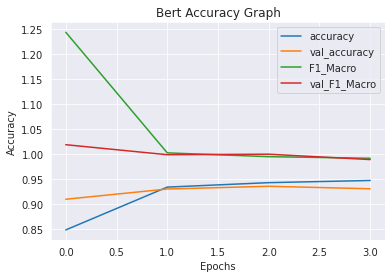

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


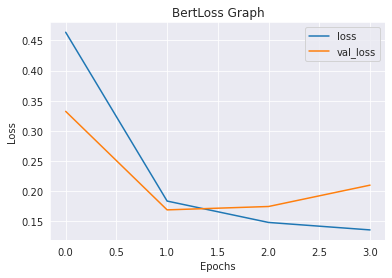

The Model Saved
The PreTrained Transformer Model Saved
The Tokenizer Saved
Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 275)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 275)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109486854  ['input_ids[0][0]',              
 ation_14 (TFBertForSequenceCla  rOutput(loss=None,               'attention_mask[0][0]']         
 ssification)                   logits=(None, 6),                                                 
                

In [282]:
# Bert Model
doTrainningModel('Bert',
                 'bert-base-uncased')

In [283]:
timeData = pd.read_csv('/models/Stats/TimeData.csv',index_col=0)
timeData

,Training(min),Evalution(min)
Models,,
Bert,39.898933,NaN


### DistilBert

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_989']
You should probably TRAIN this model on a down-stream task to be able to use 

Epoch 1/4
1000/1000 [==============================] - 307s 297ms/step - loss: 0.5544 - accuracy: 0.8157 - F1_Macro: 1.3235 - val_loss: 0.2269 - val_accuracy: 0.9170 - val_F1_Macro: 1.0097
Epoch 2/4
1000/1000 [==============================] - 296s 296ms/step - loss: 0.1930 - accuracy: 0.9327 - F1_Macro: 1.0113 - val_loss: 0.2084 - val_accuracy: 0.9300 - val_F1_Macro: 0.9935
Epoch 3/4
1000/1000 [==============================] - 296s 296ms/step - loss: 0.1389 - accuracy: 0.9458 - F1_Macro: 0.9931 - val_loss: 0.1865 - val_accuracy: 0.9315 - val_F1_Macro: 0.9956
Epoch 4/4
1000/1000 [==============================] - 296s 296ms/step - loss: 0.1115 - accuracy: 0.9582 - F1_Macro: 0.9807 - val_loss: 0.2091 - val_accuracy: 0.9300 - val_F1_Macro: 0.9928


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


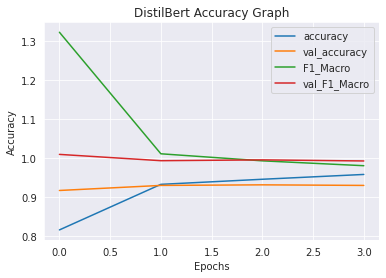

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


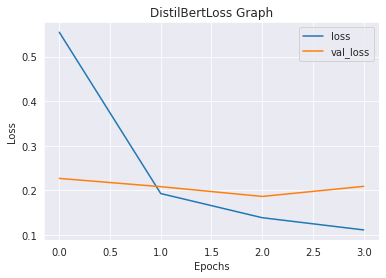

The Model Saved
The PreTrained Transformer Model Saved
The Tokenizer Saved
Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 275)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 275)]        0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66958086   ['input_ids[0][0]',              
 assification_3 (TFDistilBertFo  rOutput(loss=None,               'attention_mask[0][0]']         
 rSequenceClassification)       logits=(None, 6),                                                 
                

In [284]:
# DistilBert Model

doTrainningModel('DistilBert',
                 'distilbert-base-uncased')

In [19]:
timeData = pd.read_csv('/models/Stats/TimeData.csv',index_col=0)
timeData

,Training(min),Evalution(min)
Models,,
Bert,39.898933,NaN
DistilBert,20.787233,NaN


### Roberta

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
1000/1000 [==============================] - 610s 589ms/step - loss: 0.5201 - accuracy: 0.8290 - F1_Macro: 1.2747 - val_loss: 0.2330 - val_accuracy: 0.9155 - val_F1_Macro: 0.9998
Epoch 2/4
1000/1000 [==============================] - 585s 585ms/step - loss: 0.2390 - accuracy: 0.9193 - F1_Macro: 1.0232 - val_loss: 0.1515 - val_accuracy: 0.9325 - val_F1_Macro: 1.0100
Epoch 3/4
1000/1000 [==============================] - 585s 585ms/step - loss: 0.1758 - accuracy: 0.9338 - F1_Macro: 1.0049 - val_loss: 0.1402 - val_accuracy: 0.9430 - val_F1_Macro: 1.0108
Epoch 4/4
1000/1000 [==============================] - 585s 585ms/step - loss: 0.1630 - accuracy: 0.9364 - F1_Macro: 1.0033 - val_loss: 0.1869 - val_accuracy: 0.9365 - val_F1_Macro: 0.9707


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


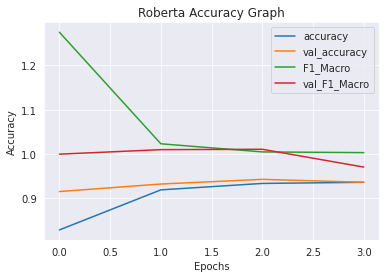

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


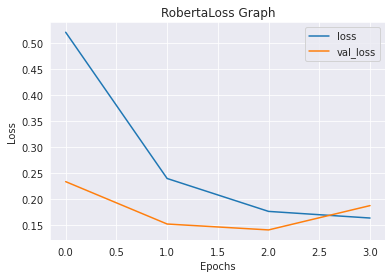

The Model Saved
The PreTrained Transformer Model Saved
The Tokenizer Saved
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 275)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 275)]        0           []                               
                                                                                                  
 tf_roberta_for_sequence_classi  TFSequenceClassifie  124650246  ['input_ids[0][0]',              
 fication (TFRobertaForSequence  rOutput(loss=None,               'attention_mask[0][0]']         
 Classification)                logits=(None, 6),                                                 
                   

In [20]:
# Roberta Model

doTrainningModel('Roberta',
                 'roberta-base')

In [21]:
timeData = pd.read_csv('/models/Stats/TimeData.csv',index_col=0)
timeData

,Training(min),Evalution(min)
Models,,
Bert,39.898933,NaN
DistilBert,20.787233,NaN
Roberta,40.637583,NaN


### Electra

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.9M [00:00<?, ?B/s]

Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraForSequenceClassification: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1000/1000 [==============================] - 192s 171ms/step - loss: 0.8632 - accuracy: 0.6904 - F1_Macro: 1.7548 - val_loss: 0.3566 - val_accuracy: 0.8910 - val_F1_Macro: 1.0103
Epoch 2/4
1000/1000 [==============================] - 167s 167ms/step - loss: 0.3143 - accuracy: 0.8971 - F1_Macro: 1.0646 - val_loss: 0.2111 - val_accuracy: 0.9265 - val_F1_Macro: 0.9778
Epoch 3/4
1000/1000 [==============================] - 168s 168ms/step - loss: 0.1940 - accuracy: 0.9268 - F1_Macro: 1.0175 - val_loss: 0.1863 - val_accuracy: 0.9360 - val_F1_Macro: 0.9942
Epoch 4/4
1000/1000 [==============================] - 168s 168ms/step - loss: 0.1712 - accuracy: 0.9332 - F1_Macro: 1.0082 - val_loss: 0.1732 - val_accuracy: 0.9315 - val_F1_Macro: 0.9947


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


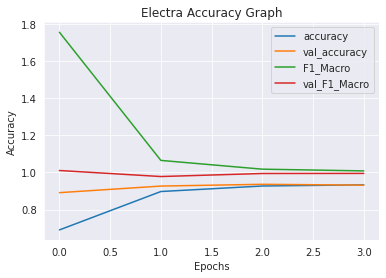

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


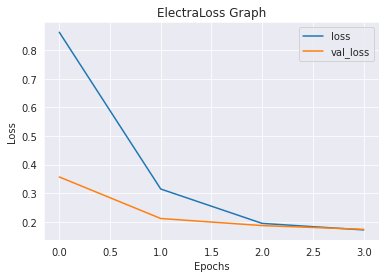

The Model Saved
The PreTrained Transformer Model Saved
The Tokenizer Saved
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 275)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 275)]        0           []                               
                                                                                                  
 tf_electra_for_sequence_classi  TFSequenceClassifie  13550342   ['input_ids[0][0]',              
 fication (TFElectraForSequence  rOutput(loss=None,               'attention_mask[0][0]']         
 Classification)                logits=(None, 6),                                                 
                 

In [22]:
# Electra Model

doTrainningModel('Electra',
                 'google/electra-small-discriminator')

In [19]:
timeData = pd.read_csv('/models/Stats/TimeData.csv',index_col=0)
timeData

,Training(min),Evalution(min)
Models,,
Bert,39.898933,NaN
DistilBert,20.787233,NaN
Roberta,40.637583,NaN
Electra,12.080952,NaN


### MobileBert

All model checkpoint layers were used when initializing TFMobileBertForSequenceClassification.

Some layers of TFMobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1000/1000 [==============================] - 498s 433ms/step - loss: 1.0766 - accuracy: 0.5811 - F1_Macro: 2.3875 - val_loss: 0.5534 - val_accuracy: 0.8065 - val_F1_Macro: 1.0851
Epoch 2/4
1000/1000 [==============================] - 418s 418ms/step - loss: 0.3581 - accuracy: 0.8839 - F1_Macro: 1.1343 - val_loss: 0.2609 - val_accuracy: 0.9130 - val_F1_Macro: 1.0765
Epoch 3/4
1000/1000 [==============================] - 417s 417ms/step - loss: 0.2585 - accuracy: 0.9204 - F1_Macro: 1.0484 - val_loss: 0.3970 - val_accuracy: 0.9115 - val_F1_Macro: 1.2860
Epoch 4/4
1000/1000 [==============================] - 417s 417ms/step - loss: 0.2419 - accuracy: 0.9246 - F1_Macro: 1.0384 - val_loss: 0.2130 - val_accuracy: 0.9335 - val_F1_Macro: 1.0104


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


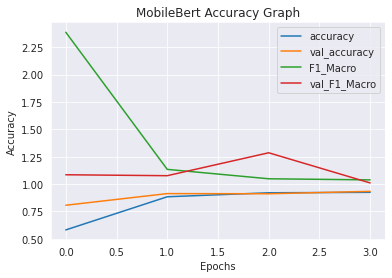

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


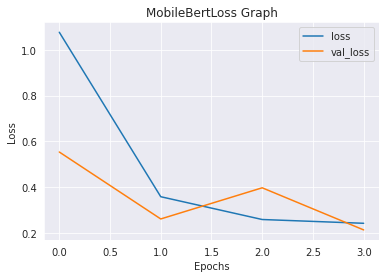

The Model Saved
The PreTrained Transformer Model Saved
The Tokenizer Saved
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 275)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 275)]        0           []                               
                                                                                                  
 tf_mobile_bert_for_sequence_cl  TFSequenceClassifie  24584966   ['input_ids[0][0]',              
 assification (TFMobileBertForS  rOutput(loss=None,               'attention_mask[0][0]']         
 equenceClassification)         logits=(None, 6),                                                 
                   

In [20]:
# MobileBert Model
doTrainningModel('MobileBert',
                 'google/mobilebert-uncased')

In [21]:
timeData = pd.read_csv('/models/Stats/TimeData.csv',index_col=0)
timeData

,Training(min),Evalution(min)
Models,,
Bert,39.898933,NaN
DistilBert,20.787233,NaN
Roberta,40.637583,NaN
Electra,12.080952,NaN
MobileBert,30.145858,NaN


### Saving Everything to Google Storage Bucket

In [ ]:
!gsutil cp -r /models/Bert gs://emotion-models/
!gsutil cp -r /models/DistilBert gs://emotion-models/
!gsutil cp -r /models/Electra gs://emotion-models/
!gsutil cp -r /models/MobileBert gs://emotion-models/
!gsutil cp -r /models/Roberta gs://emotion-models/
!gsutil cp -r /models/Stats gs://emotion-models/


# **Model Validation**
- Getting Models From Cloud Storage
- Predict Emotion
- Requried Entites 
- Thresholds 
- Model Evalution

### Getting Models From Cloud Storage
- Imported all trained model weights, tokenizer and PreTrainedModels from the cloud.


In [ ]:
!gsutil cp -r gs://emotion-models/* /models/

## Predict Emotion
- PredictEmotion Class
- PredictEmotion TestData


In [24]:
class PredictEmotion:
  def __init__(self,
               # The Name of the model
               modelName, 
               # The Path of trained model weights 
               modelPath,
               # The Path of Pre-trained Transformers model
               modelPreTrainedPath,
               # The number of Classification Labels
               numLabels = 6,
               # The probability threshold,
               thrushHold = 0.3):
    self.modelPreTrainedPath = modelPreTrainedPath
    self.modelName = modelName
    self.modelPath = modelPath
    self.numLabels = numLabels
    self.model = self.MakeModelArchitecture()
    self.loadModelWeights()
    self.tokenizer = self.makeTokenizer()
    self.spell = Speller(lang='en')
    # The six emotion labels and other when probality is lower than threshold
    self.emotionTypes = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise','other']
    self.thrushHold = thrushHold
  # Since we were saving weights, we needed to remake the model architecture to read in the weights.
  def MakeModelArchitecture(self):
    model = TFAutoModelForSequenceClassification.from_pretrained(self.modelPreTrainedPath, 
                                                                 local_files_only=True)
    input_ids = tf.keras.layers.Input(shape=(200,),name="input_ids", dtype='int32')
    mask = tf.keras.layers.Input(shape=(200,),name="attention_mask",dtype='int32')
    embeddings = model(input_ids,attention_mask=mask)[0]
    layer = tf.keras.layers.Dense(1000,activation='relu')(embeddings)
    layer = tf.keras.layers.BatchNormalization()(layer)
    outputLayer = tf.keras.layers.Dense(6,activation='softmax',name='outputs')(layer)
    ModelArchitecture = tf.keras.Model(inputs=[input_ids,mask],outputs=outputLayer)
    return ModelArchitecture
  # Using the model from the MakeModelArchitecture to read in trained weights.  
  def loadModelWeights(self):
    self.model.load_weights(self.modelPath)
  # Tokenizer to convert inputs to encodings
  def makeTokenizer(self):
    return AutoTokenizer.from_pretrained(self.modelName)
  # Prepareing the Text as seen before and returning in the format of input_ids and attention_mask .
  def TextPrepration(self,text):
    DecontractedText = contractions.fix(text)
    SpelledText = str(self.spell(DecontractedText))
    textEncodings = self.tokenizer(SpelledText,
                            truncation=True, 
                            max_length = 200,
                            padding="max_length", 
                            return_tensors='tf')
    return {
      'input_ids': tf.cast(textEncodings['input_ids'],tf.int32),
      'attention_mask': tf.cast(textEncodings['attention_mask'],tf.int32)}
  # Predicting Text emotion, if the argmax probablity is higher than the threshold, return emotion and probality else returns 'other' and threshold
  def PredictTextEmotion(self,text):
    prepratedText = self.TextPrepration(text)
    emotion = self.model.predict(prepratedText) 
    predictedEmotion = np.argmax(emotion)
    highestProb = emotion[0][predictedEmotion]
    if highestProb < self.thrushHold:
      return self.emotionTypes[len(self.emotionTypes)-1], self.thrushHold
    else:
      return self.emotionTypes[predictedEmotion],highestProb


In [25]:
# This function takes in inilizied PredictEmotion class as 'predict' and testData as 'testDataSet'
# Returns total time it took for completing the predictions and the predictedLabels 

def predictEmotionTestData(predict,testDataSet):
  predictedLabels = []
  startTime = time.time()
  for i in testDataSet:
    emotion,prob = predict.PredictTextEmotion(i)
    predictedLabels.append(emotion)
  endTime = time.time()
  elapasedTime = (endTime-startTime)/60
  return elapasedTime,predictedLabels


In [26]:
# This Function Calculats and appends F1-Scores to a pandas DataFrame.
# Takes in trueEmotionLabels and predictedEmotionLabels for data wise. 
# Takes an existing F1ScoresDataFrame and AppendingModelName to set the scores of the model in the data frame
def appendF1ModelScores(trueEmotionLabels,
                        predictedEmotionLabels,
                        F1ScoresDataFrame,
                        AppendingModelName):
  f1Report = classification_report(trueEmotionLabels, predictedEmotionLabels,output_dict=True)
  f1_scores = pd.DataFrame(f1Report).transpose()
  f1_scores = f1_scores.loc[:,['f1-score']]
  if len(list(f1_scores['f1-score'][:])) == 10:
    scores = np.delete((list(f1_scores['f1-score'][:])),4)
  else:
    scores = list(f1_scores['f1-score'][:])
  F1ScoresDataFrame[AppendingModelName] = scores
  return F1ScoresDataFrame

In [27]:
# Source code credit for this function: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, 
                           class_names,
                           ModelTitle,
                           savePath = "" ,
                           figsize = (10,7), 
                           fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True,cmap='coolwarm', linecolor='white', fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')
    plt.title(ModelTitle)
    plt.savefig(savePath,format='eps')


## Requried Entities 


In [39]:
# Pandas DataFrame torecord f1-scores . 
F1ModelScores = pd.DataFrame(index=['anger', 'fear', 'joy', 'love' ,'sadness', 'surprise', 'accuracy',
       'macro avg', 'weighted avg']).rename_axis('Emotion', axis=1)

In [40]:
# The 6 emotion Labels
labels = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
# The Test True Labels
testLabels = list(testData['Label'])

In [41]:
# Pandas DataFrame to contain all f1-scores for different thresholds for all models
threshHoldStats = pd.DataFrame(index=['30%','50%','70%']).rename_axis('Threshold', axis=1)

## Thresholds
- Function called doThesholds, takes testData with true labels with a modelName('bert-base-uncased') and threshold.
- Returns elapasedTime,predVal(predicted Labels),f1Score(Marco)

In [37]:
def doThresholds(modelName,
                 testData,
                 testDataTrueLabels,
                 Threshold):
  predictClass = PredictEmotion('/models/'+modelName+'/'+modelName+'Tokenizer/',
                              '/models/'+modelName+'/'+modelName+'Weights.h5',
                              '/models/'+modelName+'/'+modelName+'PreTrainedModel/',
                               thrushHold = Threshold)
  elapasedTime,predVal = predictEmotionTestData(predictClass,testData)
  f1Score = f1_score(testDataTrueLabels, predVal, average='macro')
  return elapasedTime,predVal,f1Score
  

### Finding F1-Scores Thresholds 
- In the Exploring Transformers in Emotion Recognition: a comparison of
BERT, DistillBERT, RoBERTa, XLNet and ELECTRA  paper, they used 0.7 threshold. To get the most performance, I am tring different Thresholds to get highest f1-scores 
- Thresholds =  {0.3,0.5,0.7}. 


In [ ]:
# Bert
Bert_elapasedTime_30,Bert_predVal_30,Bert_f1Score_30= doThresholds('Bert',
             list(testData['Text']),
             list(testData['Label']),
             0.3);
Bert_elapasedTime_50,Bert_predVal_50,Bert_f1Score_50= doThresholds('Bert',
             list(testData['Text']),
             list(testData['Label']),
             0.5);
Bert_elapasedTime_70,Bert_predVal_70,Bert_f1Score_70= doThresholds('Bert',
             list(testData['Text']),
             list(testData['Label']),
             0.7);
#DistilBert

DistilBert_elapasedTime_30,DistilBert_predVal_30,DistilBert_f1Score_30= doThresholds('DistilBert',
             list(testData['Text']),
             list(testData['Label']),
             0.3);
DistilBert_elapasedTime_50,DistilBert_predVal_50,DistilBert_f1Score_50= doThresholds('DistilBert',
             list(testData['Text']),
             list(testData['Label']),
             0.5);
DistilBert_elapasedTime_70,DistilBert_predVal_70,DistilBert_f1Score_70= doThresholds('DistilBert',
             list(testData['Text']),
             list(testData['Label']),
             0.7);
#Roberta

Roberta_elapasedTime_30,Roberta_predVal_30,Roberta_f1Score_30= doThresholds('Roberta',
             list(testData['Text']),
             list(testData['Label']),
             0.3);
Roberta_elapasedTime_50,Roberta_predVal_50,Roberta_f1Score_50= doThresholds('Roberta',
             list(testData['Text']),
             list(testData['Label']),
             0.5);
Roberta_elapasedTime_70,Roberta_predVal_70,Roberta_f1Score_70= doThresholds('Roberta',
             list(testData['Text']),
             list(testData['Label']),
             0.7);
# MobileBert

MobileBert_elapasedTime_30,MobileBert_predVal_30,MobileBert_f1Score_30= doThresholds('MobileBert',
             list(testData['Text']),
             list(testData['Label']),
             0.3);
MobileBert_elapasedTime_50,MobileBert_predVal_50,MobileBert_f1Score_50= doThresholds('MobileBert',
             list(testData['Text']),
             list(testData['Label']),
             0.5);
MobileBert_elapasedTime_70,MobileBert_predVal_70,MobileBert_f1Score_70= doThresholds('MobileBert',
             list(testData['Text']),
             list(testData['Label']),
             0.7);

# Electra

Electra_elapasedTime_30,Electra_predVal_30,Electra_f1Score_30= doThresholds('Electra',
             list(testData['Text']),
             list(testData['Label']),
             0.3);
Electra_elapasedTime_50,Electra_predVal_50,Electra_f1Score_50= doThresholds('Electra',
             list(testData['Text']),
             list(testData['Label']),
         0.5);
Electra_elapasedTime_70,Electra_predVal_70,Electra_f1Score_70= doThresholds('Electra',
             list(testData['Text']),
             list(testData['Label']),
             0.7);


In [57]:
# Setting f1-scores by thresholds into threshHoldStats
threshHoldStats.loc['30%',['Bert']] = Bert_f1Score_30
threshHoldStats.loc['50%',['Bert']] = Bert_f1Score_50
threshHoldStats.loc['70%',['Bert']] = Bert_f1Score_70 


threshHoldStats.loc['30%',['DistilBert']] = DistilBert_f1Score_30
threshHoldStats.loc['50%',['DistilBert']] = DistilBert_f1Score_50
threshHoldStats.loc['70%',['DistilBert']] = DistilBert_f1Score_70 

threshHoldStats.loc['30%',['Roberta']] = Roberta_f1Score_30
threshHoldStats.loc['50%',['Roberta']] = Roberta_f1Score_50
threshHoldStats.loc['70%',['Roberta']] = Roberta_f1Score_70 

threshHoldStats.loc['30%',['MobileBert']] = MobileBert_f1Score_30
threshHoldStats.loc['50%',['MobileBert']] = MobileBert_f1Score_50
threshHoldStats.loc['70%',['MobileBert']] = MobileBert_f1Score_70 

threshHoldStats.loc['30%',['Electra']] = Electra_f1Score_30
threshHoldStats.loc['50%',['Electra']] = Electra_f1Score_50
threshHoldStats.loc['70%',['Electra']] = Electra_f1Score_70 

threshHoldStats

Threshold,Bert,DistilBert,Roberta,MobileBert,Electra
30%,0.873612,0.873829,0.875230,0.880193,0.879371
50%,0.750838,0.747587,0.750026,0.753920,0.753539
70%,0.740324,0.749658,0.740497,0.744177,0.746670


## Model Evalutions
- Since 30% gave the highest f1-scores amoungest all models, I will be using 30% as my threshold.
- Bert Evalution
- DistilBert Evalution
- Roberta Evalution
- Electra Evalution
- MobileBert Evalution

#### Bert Evalution

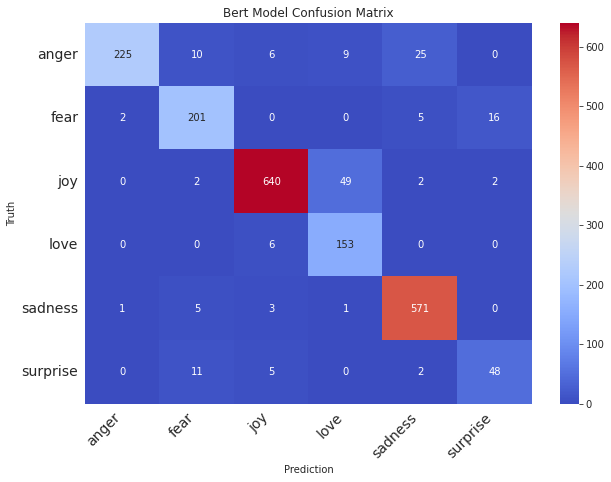

In [45]:
# Bert Evalution
timeData['Evalution(min)']['Bert'] = Bert_elapasedTime_30
F1ModelScores = appendF1ModelScores(testLabels,
                    Bert_predVal_30,
                    F1ModelScores,
                    'Bert')
BertConfusionMatrix = confusion_matrix(testLabels,Bert_predVal_30) 
print_confusion_matrix(BertConfusionMatrix,labels,'Bert Model Confusion Matrix','/models/Stats/BertConfusionMatrix.eps')


#### DistilBert Evalution

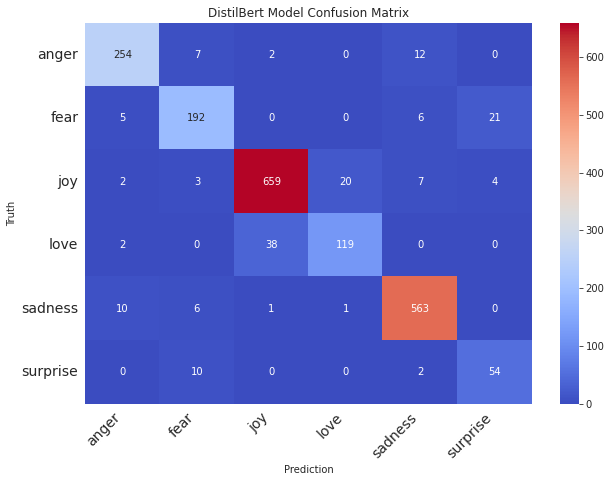

In [48]:
# DistilBert Evalution
timeData['Evalution(min)']['DistilBert'] = DistilBert_elapasedTime_30
F1ModelScores = appendF1ModelScores(list(testData['Label']),
                    DistilBert_predVal_30,
                    F1ModelScores,
                    'DistilBert')
DistilBertConfusionMatrix = confusion_matrix(testLabels,DistilBert_predVal_30) 
print_confusion_matrix(DistilBertConfusionMatrix,labels,'DistilBert Model Confusion Matrix','/models/Stats/DistilBertConfusionMatrix.eps')

#### Electra Evalution

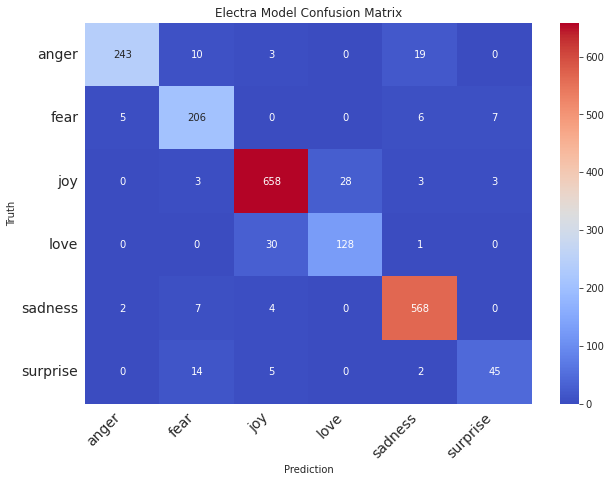

In [49]:
# Electra Evalution
timeData['Evalution(min)']['Electra'] = Electra_elapasedTime_30
F1ModelScores = appendF1ModelScores(list(testData['Label']),
                    Electra_predVal_30,
                    F1ModelScores,
                    'Electra')
ElectraConfusionMatrix = confusion_matrix(testLabels,Electra_predVal_30) 
print_confusion_matrix(ElectraConfusionMatrix,labels,
                       'Electra Model Confusion Matrix',
                       '/models/Stats/ElectraConfusionMatrix.eps')


#### Roberta Evalution

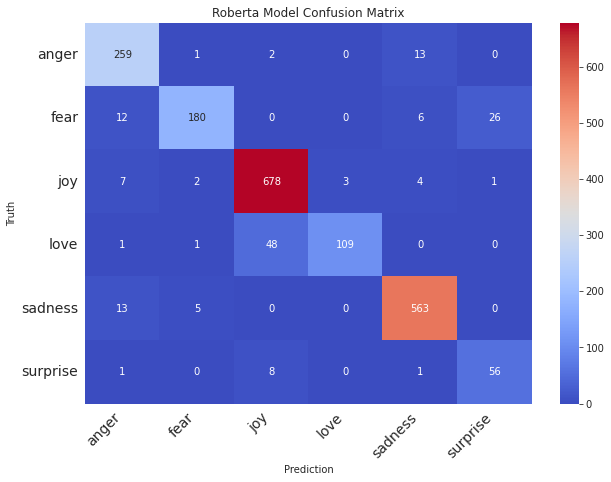

In [50]:
# Roberta Evalution
timeData['Evalution(min)']['Roberta'] = Roberta_elapasedTime_30
F1ModelScores = appendF1ModelScores(list(testData['Label']),
                    Roberta_predVal_30,
                    F1ModelScores,
                    'Roberta')
RobertaConfusionMatrix = confusion_matrix(testLabels,Roberta_predVal_30) 
print_confusion_matrix(RobertaConfusionMatrix,labels,
                       'Roberta Model Confusion Matrix',
                       '/models/Stats/RobertaConfusionMatrix.eps')

#### MobileBert Evalution

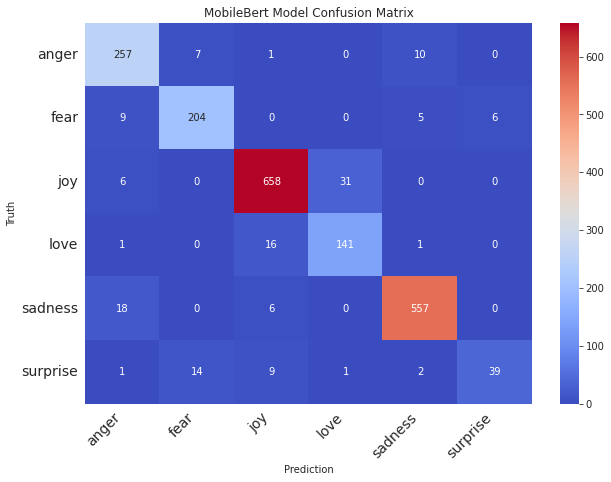

In [51]:
# MobileBert Evalution
timeData['Evalution(min)']['MobileBert'] = MobileBert_elapasedTime_30
F1ModelScores = appendF1ModelScores(list(testData['Label']),
                    MobileBert_predVal_30,
                    F1ModelScores,
                    'MobileBert')
MobileBertConfusionMatrix = confusion_matrix(testLabels,MobileBert_predVal_30) 
print_confusion_matrix(MobileBertConfusionMatrix,labels,
                       'MobileBert Model Confusion Matrix',
                       '/models/Stats/MobileBertConfusionMatrix.eps')

## About Time Data 

In [87]:
## TestDataSet Contains 2000 labels, 1 min = 60, Evalution(msg/s) = (Evalution(min)*60)/len(TestDataSet)
timeData['Evalution(msg/s)']= [timeData.loc['Bert','Evalution(min)']*60/2000,
                                 timeData.loc['DistilBert','Evalution(min)']*60/2000,
                                 timeData.loc['Electra','Evalution(min)']*60/2000,
                                 timeData.loc['Roberta','Evalution(min)']*60/2000,
                                 timeData.loc['MobileBert','Evalution(min)']*60/2000]
timeData 

,Training(min),Evalution(min),Evalution(msg/s)
Models,,,
Bert,39.898933,3.108629,0.093259
DistilBert,20.787233,2.533360,0.076001
Roberta,40.637583,3.122908,0.089810
Electra,12.080952,2.993671,0.093687
MobileBert,30.145858,7.588735,0.227662


## About Model F1-Scores

In [86]:
F1ModelScores

Emotion,Bert,DistilBert,Electra,Roberta,MobileBert
anger,0.894632,0.927007,0.925714,0.911972,0.906526
fear,0.887417,0.868778,0.887931,0.871671,0.908686
joy,0.944649,0.944803,0.943369,0.947589,0.950181
love,0.824798,0.795987,0.812698,0.804428,0.849398
sadness,0.962901,0.961571,0.962712,0.964041,0.963668
surprise,0.727273,0.744828,0.743802,0.751678,0.702703
accuracy,0.919000,0.920500,0.924000,0.922500,0.928000
macro avg,0.873612,0.873829,0.879371,0.875230,0.880193
weighted avg,0.919962,0.920282,0.923378,0.921122,0.927270


In [88]:
F1ModelScores.to_csv('/models/Stats/ModelPerformance.csv',index=True,index_label='Emotion')
timeData.to_csv('/models/Stats/TimeData.csv',index=True,index_label='Models')
threshHoldStats.to_csv('/models/Stats/ThreshHoldStats.csv',index=True,index_label='Threshold')

In [93]:
!gsutil cp -r /models/Stats/ gs://emotion-models/

Copying file:///models/Stats/DistilBertConfusionMatrix.eps [Content-Type=application/postscript]...
Copying file:///models/Stats/TimeData.csv [Content-Type=text/csv]...
Copying file:///models/Stats/RobertaConfusionMatrix.eps [Content-Type=application/postscript]...
Copying file:///models/Stats/BertConfusionMatrix.eps [Content-Type=application/postscript]...
- [4 files][225.8 KiB/225.8 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file:///models/Stats/TrainDataDestrubrition.eps [Content-Type=application/postscript]...
Copying file:///models/Stats/ElectraConfusionMatrix.eps [Content-Type=application/postscript]...
Copying file:///models/Stats/MobileBertConfusionMatrix.eps [Content-Type=application/postscript]...
Copying file: